In [1]:
# todo:
# create df of predeal and its probability distribution (cumsum?) (NSEW x CDHSN x Trick Count).
# Show expectation?
# Create column of dict containing non-zero probs.

# Generate hands, with constraints, and their double dummy results.

# Contains example code to:
# 1. Calculate distribution points.
# 2. Function to handle constraint.
# 3. Specifying a predeal string.
# 4. Generate multiple deals.
# 5. Calculate double dummy for all deals.
# 6. Create tuples of double dummy results for future processing (direction (rows) by suit (columns)).
# 7. Display hand, double dummy results

from endplay.dealer import generate_deals
from endplay.types import Deal
from endplay.dds import calc_all_tables
from endplay.evaluate import hcp

def dist_points_suit(suit, points=[3,2,1]+[0]*11):
    return points[len(suit)]

def dist_points(hand):
    return sum([dist_points_suit(suit) for suit in [hand.clubs, hand.diamonds, hand.hearts, hand.spades]])
        
def constraints(deal):
    points = hcp(deal.west)+dist_points(deal.west)-dist_points_suit(deal.west.spades)
    return points >= 11 and points <= 14 and hcp(deal.west) >= 10 and hcp(deal.west) <= 13 and len(deal.west.spades) <= 3 and len(deal.west.hearts) >= 6 and len(deal.west.hearts) <= 7 and len(deal.west.diamonds) < 5 and len(deal.west.clubs) < 5

predeal = Deal('N:... AK962.Q86.J.9743 ... ...')
swapping = 0 # either 0 (no swapping), 2 (swapping EW) or 3 (swapping EWS)
show_progress = True
produce = 100
seed = None # or any int
max_attempts = 1000000
env = dict()
strict = True

d = generate_deals(
    constraints,
    predeal=predeal,
    swapping=swapping,
    show_progress=show_progress,
    produce=produce,
    seed=seed,
    max_attempts=max_attempts,
    env=env,
    strict=strict
    )

d_t = tuple(d) # create a tuple before the storage goes wonky
batch_size = 40
t_t = []
tables = []
b_ptr = 0
for b in range(0,len(d_t),batch_size):
    batch_tables = calc_all_tables(d_t[b:min(b+batch_size,len(d_t))])
    tables.extend(batch_tables)
    batch_t_t = (tt._data.resTable for tt in batch_tables)
    t_t.extend(batch_t_t)
    b_ptr += b

print(len(d_t),len(t_t),len(tables))
rows = []
max_display = 4
direction_order = [0,2,3,1]
suit_order = [3,2,1,0,4]
for ii,(dd,sd,tt) in enumerate(zip(d_t,t_t,tables)):
    if ii < max_display:
        print(f"Deal: {ii+1}")
        dd.pprint()
        print()
        tt.pprint()
        print(tuple(tuple(sd[suit][direction] for suit in suit_order) for direction in direction_order))
        print()
    nswe_flat_l = [sd[suit][direction] for direction in direction_order for suit in suit_order]
    rows.append([dd.to_pbn()]+nswe_flat_l)


Produced: 100%|████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.49deals/s, success=1.34%]


100 100 100
Deal: 1
              J87543
              7
              98542
              K
QT                          AK962
AKJ942                      Q86
73                          J
852                         9743
              ---
              T53
              AKQT6
              AQJT6

     ♣  ♦  ♥  ♠ NT
  N 10 12  4  7  3
  S 10 12  4  7  3
  W  3  0  7  5  3
  E  3  0  7  5  3
((10, 12, 4, 7, 3), (10, 12, 4, 7, 3), (3, 0, 7, 5, 3), (3, 0, 7, 5, 3))

Deal: 2
              JT75
              75
              954
              AQ65
83                          AK962
AKT9432                     Q86
KT2                         J
T                           9743
              Q4
              J
              AQ8763
              KJ82

     ♣  ♦  ♥  ♠ NT
  N  7  8  1  6  4
  S  7  8  1  6  4
  W  6  5 11  7  8
  E  6  5 11  7  8
((7, 8, 1, 6, 4), (7, 8, 1, 6, 4), (6, 5, 11, 7, 8), (6, 5, 11, 7, 8))

Deal: 3
              843
              J3
              AQ653
              T85


In [2]:
import pandas as pd

df = pd.DataFrame(rows,columns=['Deal']+[d+s for d in list('NSWE') for s in list('CDHSN')])
df

,Deal,NC,ND,NH,NS,NN,SC,SD,SH,SS,...,WC,WD,WH,WS,WN,EC,ED,EH,ES,EN
0,N:J87543.7.98542.K AK962.Q86.J.9743 .T53.AKQT6...,10,12,4,7,3,10,12,4,7,...,3,0,7,5,3,3,0,7,5,3
1,N:JT75.75.954.AQ65 AK962.Q86.J.9743 Q4.J.AQ876...,7,8,1,6,4,7,8,1,6,...,6,5,11,7,8,6,5,11,7,8
2,N:843.J3.AQ653.T85 AK962.Q86.J.9743 QJ75.K5.T9...,3,7,3,5,5,3,8,3,6,...,8,5,10,7,7,8,5,10,7,6
3,N:Q3.43.K62.AKT652 AK962.Q86.J.9743 T874.T5.AQ...,7,9,3,5,5,7,9,3,5,...,5,2,10,7,4,5,2,10,7,4
4,N:T43.A.9853.AT652 AK962.Q86.J.9743 87.T54.AKQ...,9,11,4,4,8,9,11,4,4,...,4,0,9,8,3,4,0,9,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,N:87.AT5.9432.AKQ8 AK962.Q86.J.9743 T54.3.KQT8...,8,10,3,5,5,8,10,3,5,...,5,3,10,8,6,5,3,10,8,6
96,N:Q873.JT.AT763.65 AK962.Q86.J.9743 T4.3.KQ942...,7,9,1,3,3,7,9,1,3,...,4,4,11,8,7,4,4,11,8,7
97,N:J85.J42.Q6542.AJ AK962.Q86.J.9743 T73.5.AKT7...,4,9,2,2,2,4,9,2,2,...,8,3,10,10,6,8,3,9,9,6
98,N:83.T72.AKQ83.KJ8 AK962.Q86.J.9743 QJ54.K.T76...,3,9,3,4,4,3,9,3,4,...,10,4,10,9,7,10,4,10,8,7


predeal:N:... AK962.Q86.J.9743 ... ... samples:100


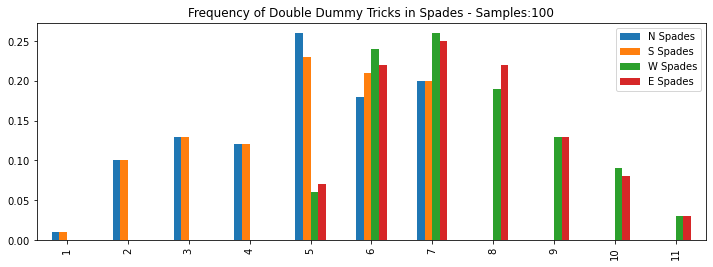

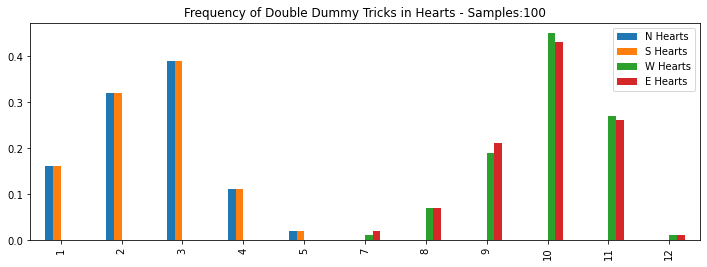

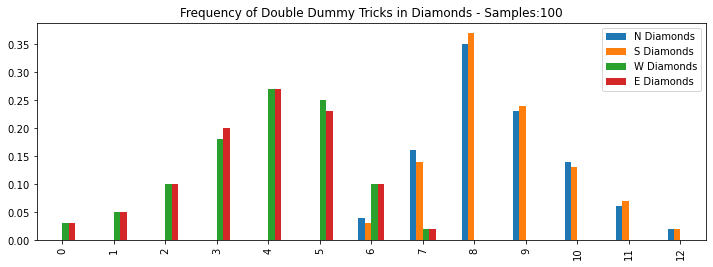

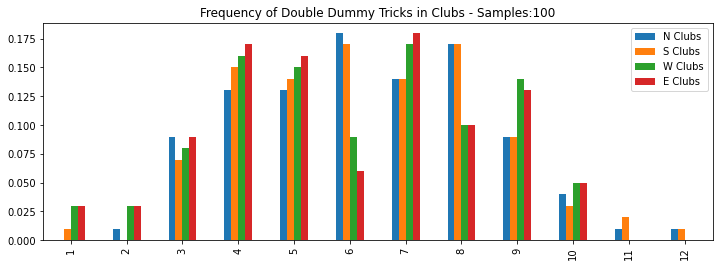

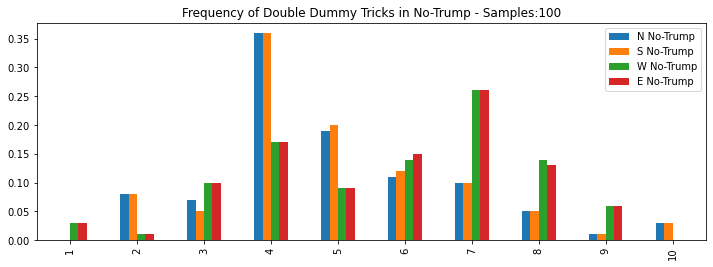

In [3]:
print(f"predeal:{predeal} samples:{len(df)}")
suit_names_d = {'S':'Spades','H':'Hearts','D':'Diamonds','C':'Clubs','N':'No-Trump'}
for s in list('SHDCN'):
    plot_d = {}
    for d in list('NSWE'):
        suit_name = suit_names_d[s]
        plot_d[d+' '+suit_name] = df[d+s].value_counts(normalize=True).sort_index()
    pd.DataFrame(plot_d).plot.bar(figsize=(12,4),title=f"Frequency of Double Dummy Tricks in {suit_name} - Samples:{len(df)}")

In [11]:
probs_df = pd.DataFrame()
probs_df.index.name='Tricks'
for s in list('SHDCN'):
    for d in list('NSWE'):
        suit_name = suit_names_d[s]
        # assign trick count probabilities to column. Reindex to always use 0-13 filling with zero where needed.
        probs_df[d+' '+suit_name] = df[d+s].value_counts(normalize=True).reindex(range(14), fill_value=0)
display(probs_df)

,N Spades,S Spades,W Spades,E Spades,N Hearts,S Hearts,W Hearts,E Hearts,N Diamonds,S Diamonds,W Diamonds,E Diamonds,N Clubs,S Clubs,W Clubs,E Clubs,N No-Trump,S No-Trump,W No-Trump,E No-Trump
Tricks,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.01,0.01,0.00,0.00,0.16,0.16,0.00,0.00,0.00,0.00,0.05,0.05,0.00,0.01,0.03,0.03,0.00,0.00,0.03,0.03
2,0.10,0.10,0.00,0.00,0.32,0.32,0.00,0.00,0.00,0.00,0.10,0.10,0.01,0.00,0.03,0.03,0.08,0.08,0.01,0.01
3,0.13,0.13,0.00,0.00,0.39,0.39,0.00,0.00,0.00,0.00,0.18,0.20,0.09,0.07,0.08,0.09,0.07,0.05,0.10,0.10
4,0.12,0.12,0.00,0.00,0.11,0.11,0.00,0.00,0.00,0.00,0.27,0.27,0.13,0.15,0.16,0.17,0.36,0.36,0.17,0.17
5,0.26,0.23,0.06,0.07,0.02,0.02,0.00,0.00,0.00,0.00,0.25,0.23,0.13,0.14,0.15,0.16,0.19,0.20,0.09,0.09
6,0.18,0.21,0.24,0.22,0.00,0.00,0.00,0.00,0.04,0.03,0.10,0.10,0.18,0.17,0.09,0.06,0.11,0.12,0.14,0.15
7,0.20,0.20,0.26,0.25,0.00,0.00,0.01,0.02,0.16,0.14,0.02,0.02,0.14,0.14,0.17,0.18,0.10,0.10,0.26,0.26
8,0.00,0.00,0.19,0.22,0.00,0.00,0.07,0.07,0.35,0.37,0.00,0.00,0.17,0.17,0.10,0.10,0.05,0.05,0.14,0.13
